# Wave Height Prediction Model From Offshore Buoy Data

This notebook builds a model to predict max daily observed waveheight on north Oahu from offshore buoy data. See `data-processing.ipynb` for data processing and exploratory plots.

We want to predict `Obs`, which is the maximum wave height observed on northshore Oahu in Hawaii scale feet, based on our feature variables:

- `WVHT` - Max daily wave height (m) recorded on the offshore buoy.
- `DPD` - Dominant wave period (s) at the time of daily max wave height.
- `MWD` - Mean wave direction (angle in degrees) at the time of daily max wave height.
- `WVHT_Mean` - Mean daily waveheight recording (m).
- `WVHT_Var` - The variance of waveheight recorded on a day.

As well as taking seasonal patterns into account.


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [95]:
color_pal = sns.color_palette()

## Importing Processed Data

In [96]:
data = pd.read_csv('processed_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

WVHT    DPD    MWD  WVHT_Mean  WVHT_Var  Obs
Date                                                    
2009-12-31  2.83  13.33  319.0   2.405833  0.030899  NaN
2010-01-01  2.28  11.11  332.0   1.967917  0.031417  6.0
2010-01-02  1.96  15.38  314.0   1.712308  0.019754  7.0
2010-01-03  1.84  14.29  319.0   1.518462  0.014574  6.0
2010-01-04  2.15  11.11  312.0   1.938889  0.021481  6.0

Remove rows with any `NaN` values.

In [97]:
data = data.dropna()

### Basic Plot of Prediction Variable and Primary Feature Variable

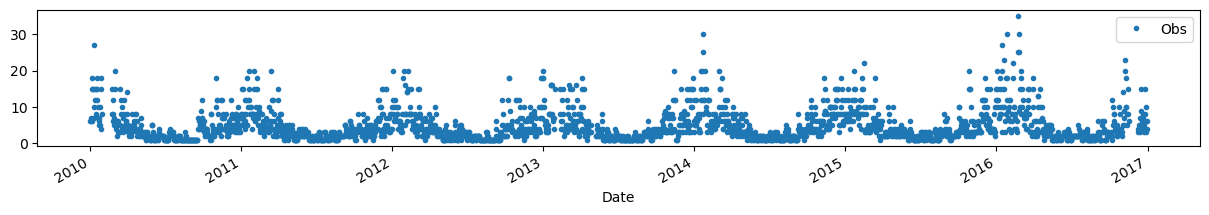

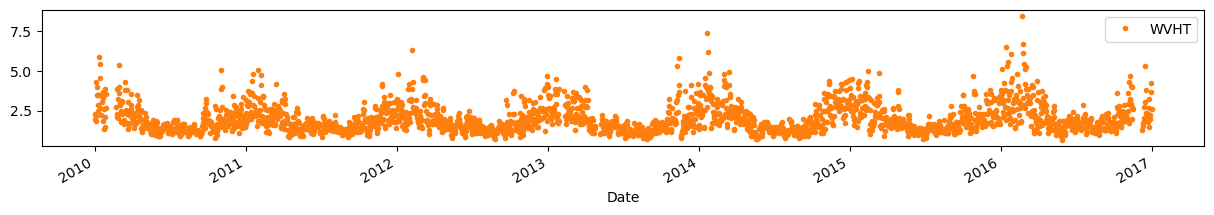

In [98]:
data.plot(y = 'Obs', style = '.', figsize = (15, 2), color = color_pal[0])
data.plot(y = 'WVHT', style = '.', figsize = (15, 2), color = color_pal[1])
plt.show()

## Time Series Feature Creation

In [99]:
data['Month'] = data.index.month
data['Week'] = data.index.isocalendar().week.astype('int32')
data.head()

WVHT    DPD    MWD  WVHT_Mean  WVHT_Var   Obs  Month  Week
Date                                                                  
2010-01-01  2.28  11.11  332.0   1.967917  0.031417   6.0      1    53
2010-01-02  1.96  15.38  314.0   1.712308  0.019754   7.0      1    53
2010-01-03  1.84  14.29  319.0   1.518462  0.014574   6.0      1    53
2010-01-04  2.15  11.11  312.0   1.938889  0.021481   6.0      1     1
2010-01-05  4.30  14.29  315.0   3.293077  0.328606  18.0      1     1

## Visualise Time Series Feature / Target Relationship

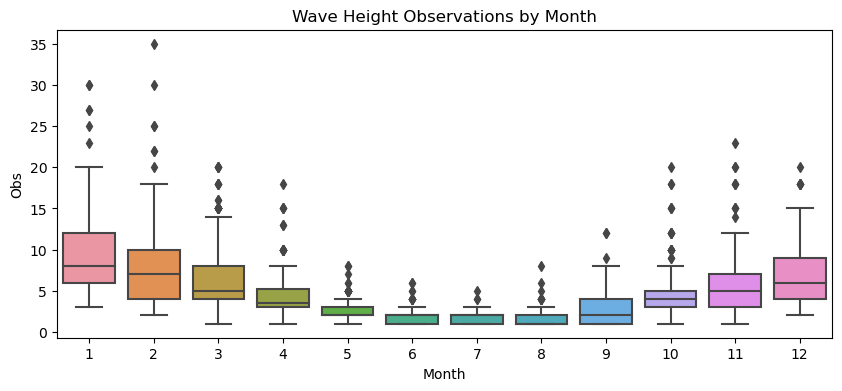

In [100]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data = data, x = 'Month', y = 'Obs')
ax.set_title('Wave Height Observations by Month')
plt.show()

##Â Train / Test Split

Make copies so that we do not get the `SettingWithCopyWarning` error later.

In [101]:
train = data.loc[data.index < '01-01-2015'].copy()
test = data.loc[data.index >= '01-01-2015'].copy()

In [102]:
FEATURES = ['WVHT', 'DPD', 'MWD', 'WVHT_Mean', 'WVHT_Var', 'Month', 'Week']
TARGET = 'Obs'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

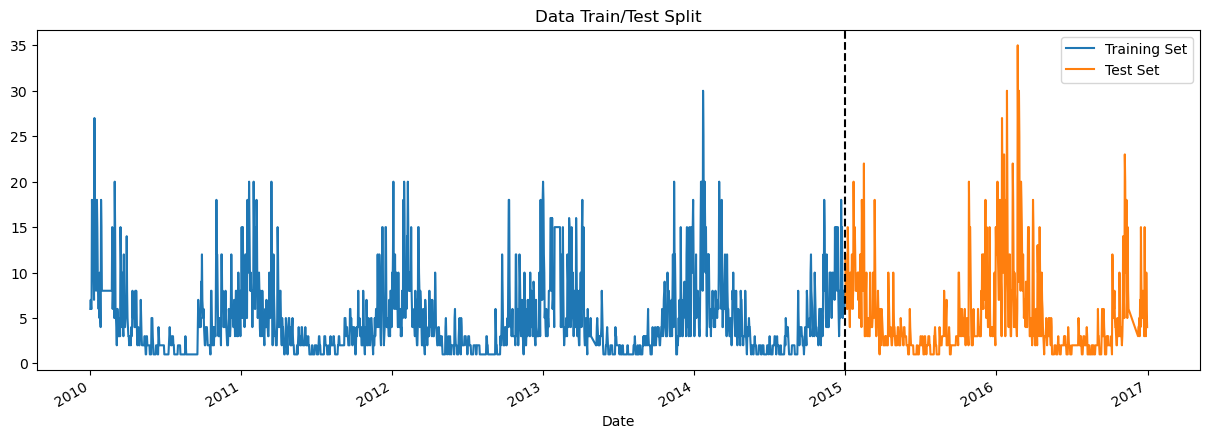

In [103]:
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(y = 'Obs', ax = ax, label = 'Training Set', title='Data Train/Test Split')
test.plot(y = 'Obs', ax = ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Model 1 - Linear Regression

In [104]:
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

LinearRegression()

## Forecast on Test

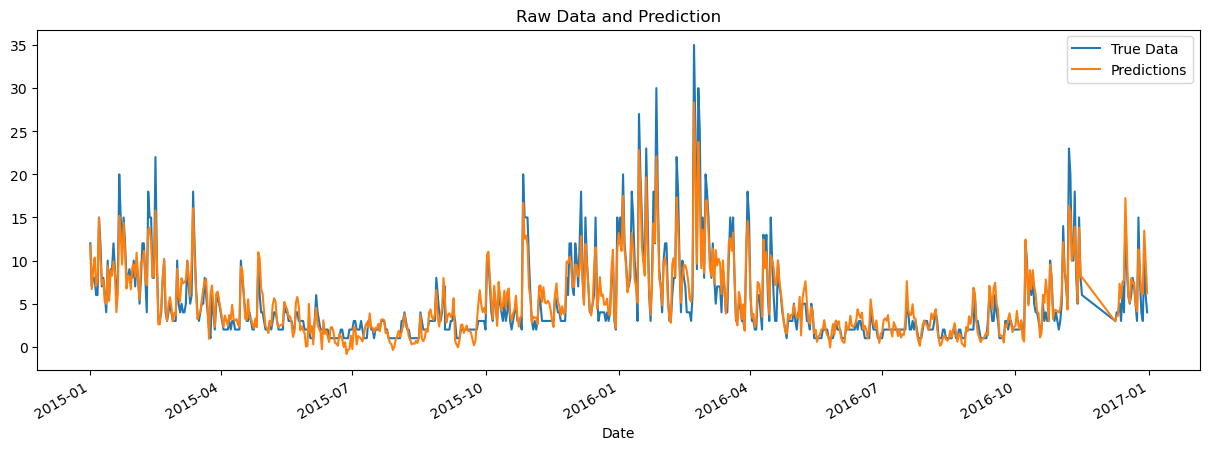

In [105]:
pred1 = model.predict(X_test)
    
test['prediction'] = pred1

ax = test[[TARGET]].plot(figsize = (15, 5))
test['prediction'].plot(ax = ax)
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

## Score RMSE

In [106]:
score = np.sqrt(mean_squared_error(test[TARGET], pred1))

print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.66


# Model 2 - Boosted Tree

In [107]:
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',    
                       n_estimators = 1000,
                       early_stopping_rounds = 50,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 200)

[14:59:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.65008	validation_1-rmse:6.59368
[200]	validation_0-rmse:1.47803	validation_1-rmse:1.81696
[400]	validation_0-rmse:1.09999	validation_1-rmse:1.37774
[600]	validation_0-rmse:1.04240	validation_1-rmse:1.33965
[678]	validation_0-rmse:1.03169	validation_1-rmse:1.34156


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importances

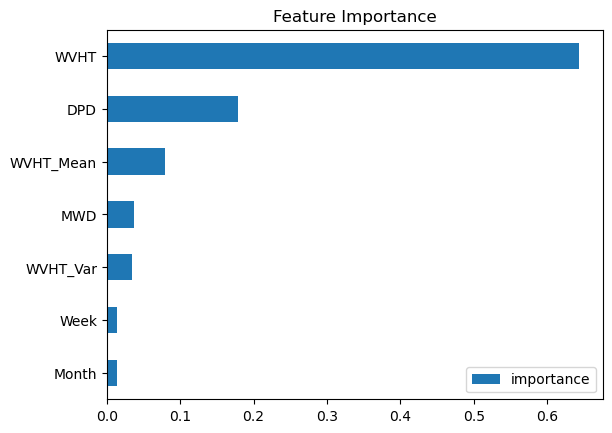

In [108]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

`WVHT` is the most important feature by far, but `DPD` is also important. The timeseries features (`Week` and `Month`) turn out to not be very important.

## Forecast on Test

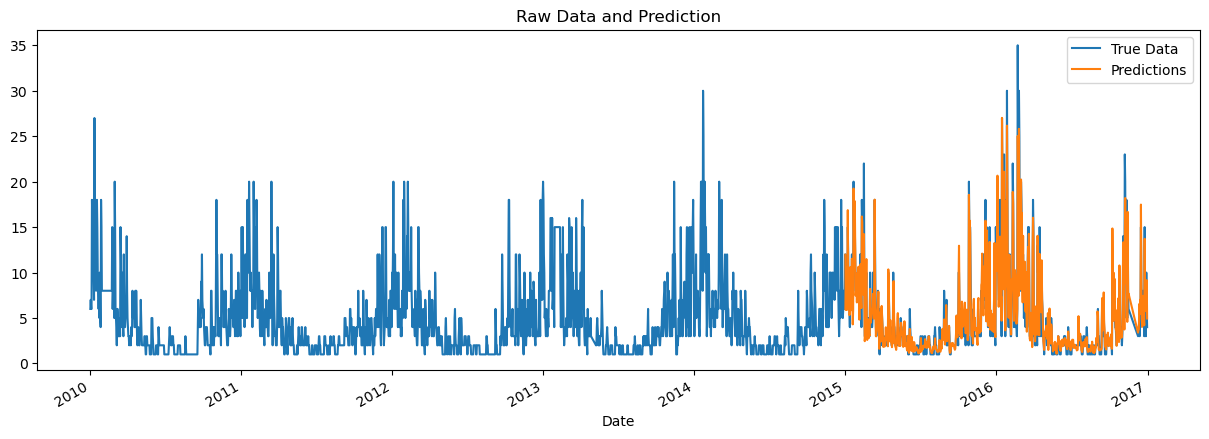

In [109]:
pred2 = reg.predict(X_test)
test['prediction'] = pred2
data = data.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

ax = data[[TARGET]].plot(figsize = (15, 5))
data['prediction'].plot(ax = ax)
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

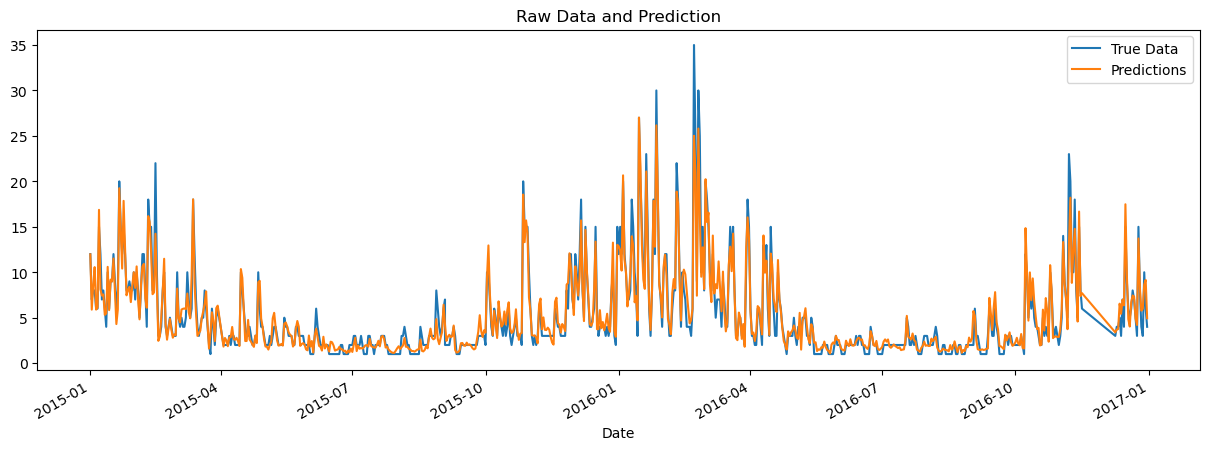

In [110]:
ax = test[[TARGET]].plot(figsize = (15, 5))
test['prediction'].plot(ax = ax)
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

## Score RMSE

In [111]:
score = np.sqrt(mean_squared_error(test[TARGET], pred2))

print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.34


Model 2 is preferred as it has a lower RMSE.

## Calculate Absolute Error

In [112]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

test.groupby(test.index.date)['error'].mean().sort_values(ascending=False).head(15)

2016-02-22    9.986029
2016-11-07    9.856259
2016-02-26    8.669287
2015-02-15    7.762504
2016-03-10    4.194995
2016-02-25    4.193148
2016-02-23    4.099951
2016-01-10    4.039392
2015-01-08    3.883742
2016-01-27    3.838812
2016-02-17    3.837047
2016-09-02    3.728484
2015-03-12    3.710598
2016-03-08    3.680421
2015-08-29    3.333581
Name: error, dtype: float64